# What drives the price of a car?

![](images/kurt.jpeg)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
contentRoot = '/content/drive/MyDrive/Github/machinelearning/used-car-pricing'

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
import numpy as np
import plotly.express as px
import pandas as pd
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline


**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.



---

#### Business Objective
The client for this task is a used car dealership, whose interests are:


1.   Identify the right price to set for a used car in their inventory
2.   Stock cars in inventory that are likely to sell

With this information, the business objectives of this task, or the outputs, can be understood as:

*   (Primary) Given the attributes of an automobile, identify the features that are a good predictor of the price at which it will sell
*   (Secondary) Given the attributes of an automobile, predict the price it will sell for
*   (Future) Identify the features that contribute most to the sale of a used car. In other words, given the attributes of a customer and an automobile, what attributes are a good predictor of a used car sale? Since the provided dataset does not have enough information to predict this outcome, this can be treated as future work.

#### Situation Assessment
The major risks and constraints associated with this task are:


*   The quality of the dataset might affect the outcome. This can be mitigated to an extent using train/test data splits
*   There could be new factors affecting the price of a used car (for example: market conditions, pandemic) which could impact the applicability of our prediction to the client.
*   The time available to complete this task is only 1 week, which is a major constraint.

#### Data Mining Goals

The goal of this task is to follow the CRISP-DM framework to deliver a README.md and Jupyter notebook of the analysis. The final result will provide clear directions to the client on how to proceed with pricing their used car inventory.

---



### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Import and explore the data

In [ ]:
data = pd.read_csv('{}/data/vehicles.csv'.format(contentRoot))
census_regions = pd.read_csv('{}/data/us_census_regions.csv'.format(contentRoot))

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [ ]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [ ]:
print(data.isna().sum())

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


In [ ]:
num_unique = data.nunique(axis=0)

print("No.of.unique values in each column :\n", num_unique)

No.of.unique values in each column :
 id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64


In [ ]:
print('Unique types in the dataset are {}'.format(data['type'].unique()))
print('Unique conditions in the dataset are {}'.format(data['condition'].unique()))
print('Unique cylinders in the dataset are {}'.format(data['cylinders'].unique()))
print('Unique fuels in the dataset are {}'.format(data['fuel'].unique()))
print('Unique title statuses in the dataset are {}'.format(data['title_status'].unique()))
print('Unique transmissions in the dataset are {}'.format(data['transmission'].unique()))
print('Unique drives in the dataset are {}'.format(data['drive'].unique()))
print('Unique paint colors in the dataset are {}'.format(data['paint_color'].unique()))
print('Unique sizes in the dataset are {}'.format(data['size'].unique()))

Unique types in the dataset are [nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
Unique conditions in the dataset are [nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']
Unique cylinders in the dataset are [nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']
Unique fuels in the dataset are [nan 'gas' 'other' 'diesel' 'hybrid' 'electric']
Unique title statuses in the dataset are [nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']
Unique transmissions in the dataset are [nan 'other' 'automatic' 'manual']
Unique drives in the dataset are [nan 'rwd' '4wd' 'fwd']
Unique paint colors in the dataset are [nan 'white' 'blue' 'red' 'black' 'silver' 'grey' 'brown' 'yellow'
 'orange' 'green' 'custom' 'purple']
Unique sizes in the dataset are [nan 'full-size' 'mid-size' 'compact' 'sub-compact']


In [ ]:
data.manufacturer.value_counts()


ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
datsun                63
aston-martin          24


In [ ]:
data.model.value_counts()

f-150                      8009
silverado 1500             5140
1500                       4211
camry                      3135
silverado                  3023
                           ... 
plymouth fury 1               1
f550 box truck delivery       1
duramax 2500hd                1
3 s sport                     1
Paige Glenbrook Touring       1
Name: model, Length: 29649, dtype: int64

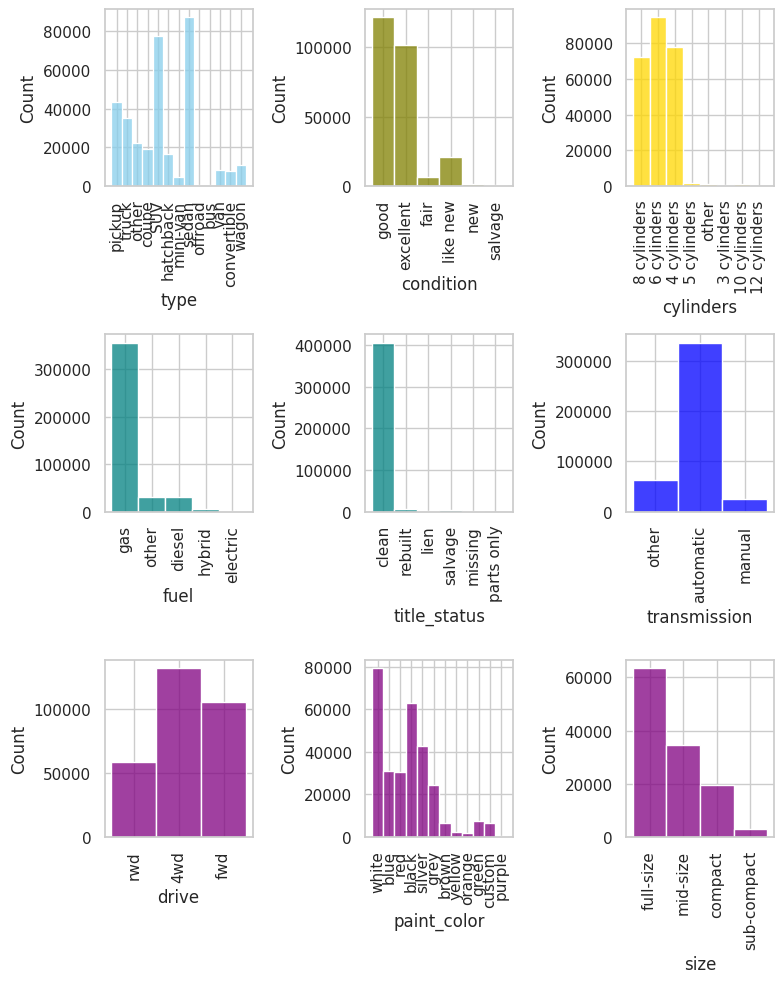

In [ ]:

sns.set(style="whitegrid")
fig,axs = plt.subplots(3,3, figsize = (8,10))
sns.histplot(data=data, x="type", kde=False, color="skyblue", ax=axs[0, 0])
sns.histplot(data=data, x="condition", kde=False, color="olive", ax=axs[0, 1])
sns.histplot(data=data, x="cylinders", kde=False, color="gold", ax=axs[0, 2])
sns.histplot(data=data, x="fuel", kde=False, color="teal", ax=axs[1, 0])
sns.histplot(data=data, x="title_status", kde=False, color="teal", ax=axs[1, 1])
sns.histplot(data=data, x="transmission", kde=False, color="blue", ax=axs[1, 2])
sns.histplot(data=data, x="drive", kde=False, color="purple", ax=axs[2,0])
sns.histplot(data=data, x="paint_color", kde=False, color="purple", ax=axs[2,1])
sns.histplot(data=data, x="size", kde=False, color="purple", ax=axs[2,2])
for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 90)
fig.tight_layout()


##### Identify the top 15 car models that fetch the highest average price

In [ ]:
print(df_cars.groupby('model').mean(numeric_only=True).nlargest(15, columns='price').index.to_list())

['corvette grand sport', '1500 crew cab big horn', 'mustang gt coupe 2d', 'camaro ss coupe 2d', 'corvette', 'tundra double cab sr', '4runner sr5 sport utility', 'challenger r/t coupe 2d', 'silverado 1500 crew', 'silverado 1500 double', 'wrangler sport suv 2d', 'tacoma double cab pickup', 'expedition xlt sport', 'wrangler unlimited sport', 'colorado extended cab']




---


##### Column Types
There are a number of categorical columns in the dataset. Many of them can be one hot encoded to prepare for analysis. The cardinality of some of these columns is pretty high, for example, `model` has 30,000 unique values, and we might have to cluster the data before one hot encoding. Other high cardinality columns are `region`, `year`, and `manufacturer`.

##### Data Quality
The data seems to have a large number of NaNs, especially the columns `size`, `condition`. `drive`, `paint_color` and `cylinders`.

##### Cleanup opportunities

*   The column `VIN` is unique to a car, and is unlikely to predict the price. This column can be dropped.
*   The `cylinders` column maybe converted to a number by mapping values.
*   For all columns, NaNs maybe treated as unknown since dropping the rows would severely impact the total rows available.
*   To eliminate noise, we might also want to limit our exploration to `manufacturer`s that have at least 5000 data rows, and `model`s that have at least 100 rows.
*   We can drop the `title_status` column given the values are almost always 'clean'
*   We can restrict our investigation to 'gas' `fuel`

##### Reduce cardinality
For some columns, reducing the cardinality might be useful
*   Keep data after year 2000
*   Remove rows that have `cylinder`s other than 4, 6, 8
*   Map states to geographic regions based on us census data
---



### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

##### Drop unnecessary columns

*   The columns `id` and `VIN` are unique to a car, they maybe dropped.
*   The column `region` has high cardinality, it maybe dropped.



In [ ]:
data_dropped_cols = data.drop([
    'id',
    'region',
    'VIN',
    'title_status'
], axis = 1)

data_dropped_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   transmission  424324 non-null  object 
 9   drive         296313 non-null  object 
 10  size          120519 non-null  object 
 11  type          334022 non-null  object 
 12  paint_color   296677 non-null  object 
 13  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 45.6+ MB


##### Drop columns with > 33% NaNs


In [ ]:
data_dropped_cols.dropna(thresh=len(data_dropped_cols)/3, axis=1, inplace=True)
data_dropped_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   transmission  424324 non-null  object 
 9   drive         296313 non-null  object 
 10  type          334022 non-null  object 
 11  paint_color   296677 non-null  object 
 12  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 42.3+ MB


The only column that dropped is `size`

##### Drop rows with irrelevant data


*   Many rows have all columns as NaN, columns with greater than 10 NaNs may be dropped
*   Many rows have a zero `price`, they may be dropped
*   Rows with outlier prices may be dropped
*   Rows with no `odometer` value may be dropped
*   Rows with no `year` value may be dropped
*   Rows with `type` gas may be retained, and others dropped
*   Rows with 4, 6, 8 `cylinder` may be retained, and others dropped

In [ ]:
data_dropped_rows = data_dropped_cols.dropna(thresh=10, axis=0)
data_dropped_rows = data_dropped_rows.query('price > 0')
p99 = data_dropped_rows['price'].quantile(.999)
print('P99 value of price was {}'.format(p99))
data_dropped_rows = data_dropped_rows.query('price < @p99')
data_dropped_rows = data_dropped_rows.query('odometer > 0')
data_dropped_rows = data_dropped_rows.query('year > 0')
data_dropped_rows = data_dropped_rows.query("fuel == 'gas'")
data_dropped_rows = data_dropped_rows.drop('fuel', axis = 1)
valid_cylinders = ['8 cylinders','6 cylinders','4 cylinders']
data_dropped_rows = data_dropped_rows.query("cylinders in @valid_cylinders")
data_dropped_rows.info()

P99 value of price was 120000.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200162 entries, 27 to 426878
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         200162 non-null  int64  
 1   year          200162 non-null  float64
 2   manufacturer  194799 non-null  object 
 3   model         198656 non-null  object 
 4   condition     154282 non-null  object 
 5   cylinders     200162 non-null  object 
 6   odometer      200162 non-null  float64
 7   transmission  199997 non-null  object 
 8   drive         171377 non-null  object 
 9   type          179337 non-null  object 
 10  paint_color   163645 non-null  object 
 11  state         200162 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 19.9+ MB


In [ ]:
data_dropped_rows.head()


,price,year,manufacturer,model,condition,cylinders,odometer,transmission,drive,type,paint_color,state
27,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,57923.0,other,NaN,pickup,white,al
28,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,71229.0,other,NaN,pickup,blue,al
29,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,19160.0,other,NaN,pickup,red,al
30,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,41124.0,other,NaN,pickup,red,al
31,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,128000.0,automatic,rwd,truck,black,al


##### Fill NaNs with `unknown`

In [ ]:
data_nona = data_dropped_rows.fillna('unknown')
data_nona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200162 entries, 27 to 426878
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         200162 non-null  int64  
 1   year          200162 non-null  float64
 2   manufacturer  200162 non-null  object 
 3   model         200162 non-null  object 
 4   condition     200162 non-null  object 
 5   cylinders     200162 non-null  object 
 6   odometer      200162 non-null  float64
 7   transmission  200162 non-null  object 
 8   drive         200162 non-null  object 
 9   type          200162 non-null  object 
 10  paint_color   200162 non-null  object 
 11  state         200162 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 19.9+ MB


##### Remove data prior to 2000

In [ ]:
data_nona = data_nona.query('year >= 2000')
data_nona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184982 entries, 27 to 426878
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         184982 non-null  int64  
 1   year          184982 non-null  float64
 2   manufacturer  184982 non-null  object 
 3   model         184982 non-null  object 
 4   condition     184982 non-null  object 
 5   cylinders     184982 non-null  object 
 6   odometer      184982 non-null  float64
 7   transmission  184982 non-null  object 
 8   drive         184982 non-null  object 
 9   type          184982 non-null  object 
 10  paint_color   184982 non-null  object 
 11  state         184982 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 18.3+ MB


##### Filter `manufacturer` and `model` to the most important ones

In [ ]:
manu_gt_5000 = pd.DataFrame(data_nona['manufacturer'].value_counts()).query("manufacturer > 5000").index.to_list()
print('Top manufacturers are {}'.format(manu_gt_5000))
data_manu_model_filtered = data_nona.query('manufacturer in @manu_gt_5000')
print('Number of rows after filtering manufacturer is {}'.format(data_manu_model_filtered.shape[0]))

top_100_models_list = data_manu_model_filtered.model.value_counts()[:100].index.to_list()
print('Top models are {}'.format(top_100_models_list))
data_manu_model_filtered = data_manu_model_filtered.query('model in @top_100_models_list')
print('Number of rows after filtering model is {}'.format(data_manu_model_filtered.shape[0]))

Top manufacturers are ['ford', 'chevrolet', 'toyota', 'honda', 'nissan', 'jeep', 'gmc', 'dodge', 'ram', 'bmw']
Number of rows after filtering manufacturer is 126012
Top models are ['f-150', 'silverado 1500', '1500', 'camry', 'accord', 'civic', 'escape', 'tacoma', 'altima', 'wrangler', 'grand cherokee', 'corolla', 'explorer', 'cr-v', 'equinox', 'silverado', 'mustang', 'rav4', 'focus', 'grand caravan', 'odyssey', 'malibu', 'fusion', 'sierra 1500', 'impala', 'tahoe', 'charger', 'wrangler unlimited', 'cruze', 'tundra', 'sienna', 'sentra', 'edge', 'highlander', 'rogue', '4runner', 'f150', 'corvette', 'pilot', 'unknown', 'suburban', '3 series', 'fusion se', 'silverado 1500 regular', 'camaro ss coupe 2d', 'traverse', 'cherokee', 'taurus', 'silverado 2500hd', 'wrangler unlimited sport', '1500 crew cab big horn', 'focus se', 'acadia', '2500', 'expedition', 'camaro', 'x5', 'mustang gt coupe 2d', 'challenger', 'patriot', 'versa', 'camry le', 'murano', 'liberty', 'pathfinder', 'civic lx', 'yukon',

##### Map states to us census regions to reduce cardinality

In [ ]:
census_regions = census_regions.drop(['State', 'Division'], axis=1)
census_regions.columns = ['state', 'census_region']
data_manu_model_filtered['state'] = data_manu_model_filtered['state'].str.upper()
data_w_region = data_manu_model_filtered.join(other=census_regions.set_index('state'), on='state')
print('Final number of rows is {}'.format(data_w_region.shape))

Final number of rows is (62129, 13)


##### Finally assign to a cleaned variable name

In [ ]:
df_cars = data_w_region.drop('state', axis=1)
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62129 entries, 28 to 426864
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          62129 non-null  int64  
 1   year           62129 non-null  float64
 2   manufacturer   62129 non-null  object 
 3   model          62129 non-null  object 
 4   condition      62129 non-null  object 
 5   cylinders      62129 non-null  object 
 6   odometer       62129 non-null  float64
 7   transmission   62129 non-null  object 
 8   drive          62129 non-null  object 
 9   type           62129 non-null  object 
 10  paint_color    62129 non-null  object 
 11  census_region  62129 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 6.2+ MB


##### Plot the histogram of all columns

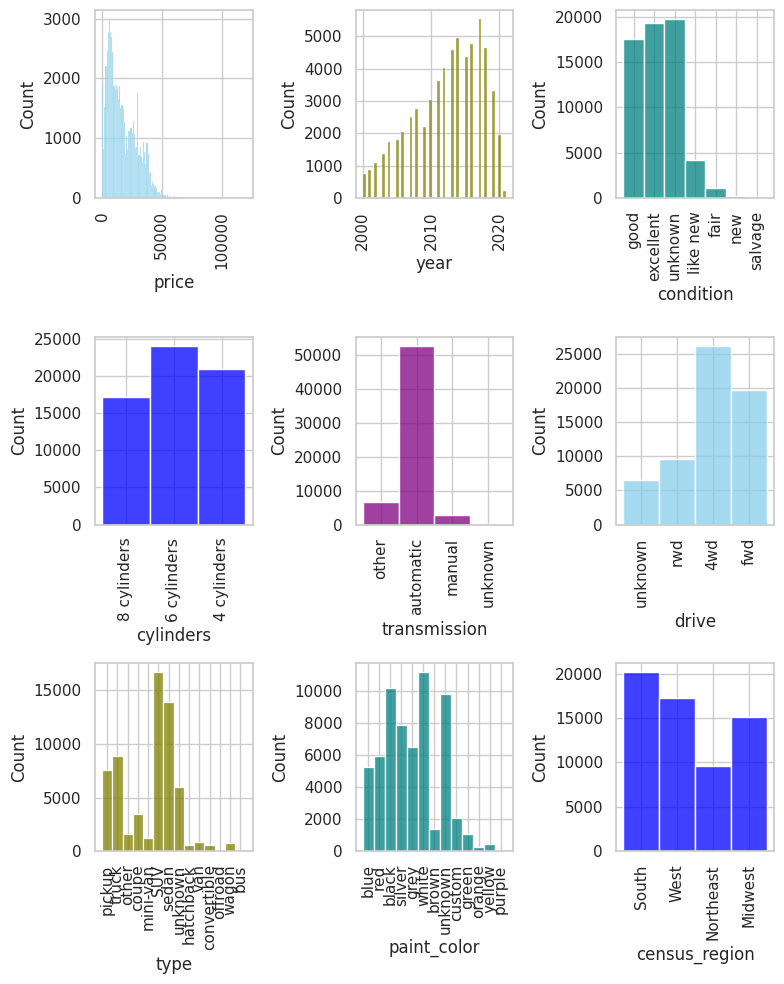

In [ ]:
sns.set(style="whitegrid")
fig,axs = plt.subplots(3,3, figsize = (8,10))
sns.histplot(data=df_cars, x="price", kde=False, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df_cars, x="year", kde=False, color="olive", ax=axs[0, 1])
sns.histplot(data=df_cars, x="condition", kde=False, color="teal", ax=axs[0, 2])
sns.histplot(data=df_cars, x="cylinders", kde=False, color="blue", ax=axs[1, 0])
sns.histplot(data=df_cars, x="transmission", kde=False, color="purple", ax=axs[1,1])
sns.histplot(data=df_cars, x="drive", kde=False, color="skyblue", ax=axs[1,2])
sns.histplot(data=df_cars, x="type", kde=False, color="olive", ax=axs[2,0])
sns.histplot(data=df_cars, x="paint_color", kde=False, color="teal", ax=axs[2,1])
sns.histplot(data=df_cars, x="census_region", kde=False, color="blue", ax=axs[2,2])

for ax in axs.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 90)
fig.tight_layout()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

##### Create train and test data

Add random state to ensure the results are consistent with each run

In [ ]:
# dropping paint color from modeling after initial model runs indicated that this feature does not add value
X = df_cars.drop(['price', 'paint_color'], axis = 1)
y = df_cars['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

X_train.head()

,year,manufacturer,model,condition,cylinders,odometer,transmission,drive,type,census_region
87769,2016.0,gmc,acadia,excellent,6 cylinders,91862.0,automatic,unknown,other,Northeast
64596,2018.0,honda,cr-v,unknown,4 cylinders,28037.0,automatic,4wd,SUV,West
87060,2015.0,honda,accord,excellent,4 cylinders,51000.0,automatic,fwd,sedan,Northeast
190260,2008.0,ford,f-150,excellent,8 cylinders,175866.0,automatic,rwd,pickup,Northeast
131449,2007.0,honda,accord,unknown,6 cylinders,135000.0,automatic,4wd,SUV,West


##### Create data transformer

In [ ]:
num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias = False))
])

transformer = make_column_transformer(
    (OneHotEncoder(), [
        'manufacturer',
        'model',
        'condition',
        'cylinders',
        'transmission',
        'drive',
        'type',
        'census_region'
    ]),
    (num_pipeline, ['year', 'odometer']),
    verbose_feature_names_out = False,
    remainder = 'passthrough',
    sparse_threshold = 0
)

##### Linear Regression Model

Run a linear model with grid search for polynomial degrees ranging from 1-4, and selecting between 2-10 features. Perform K fold cross validation with k=4.

In [ ]:
linear_model_pipe = Pipeline([
    ('pp', transformer),
    ('sfs', SequentialFeatureSelector(estimator = LinearRegression(fit_intercept=True), n_features_to_select = 2)),
    ('lr', LinearRegression(fit_intercept=True))
])

linear_param_dict = {
    'pp__pipeline__poly__degree': list(range(1, 3)),
    'sfs__n_features_to_select': list(range(2, 10))
}

linear_grid = GridSearchCV(
    estimator = linear_model_pipe,
    param_grid = linear_param_dict,
    scoring = 'neg_mean_squared_error',
    cv = 4
)

linear_grid.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['manufacturer',
                                                                          'model',
                                                                          'condition',
                                                                          'cylinders',
                                                                          'transmission',
                                                                          'drive',
                                                                          'type',
                                                                          'census_region']),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['year',
                                                                          'odometer'])],
                                                          verbose_feature_names_out=False)),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearRegression(),
                                                                  n_features_to_select=2)),
                                       ('lr', LinearRegression())]),
             param_grid={'pp__pipeline__poly__degree': [1, 2],
                         'sfs__n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [ ]:
print('Optimal Grid params were {}'.format(linear_grid.best_params_))
best_linear_model = linear_grid.best_estimator_
best_linear_model

Optimal Grid params were {'pp__pipeline__poly__degree': 2, 'sfs__n_features_to_select': 9}


Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'model',
                                                   'condition', 'cylinders',
                                                   'transmission', 'drive',
                                                   'type', 'census_region']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])],
                                   verbose_feature_names_out=False)),
                ('sfs',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=9)),
                ('lr', LinearRegression())])

In [ ]:
linear_preds = best_linear_model.predict(X_test)
print('MSE with linear regression is {}'.format(mean_squared_error(y_test, linear_preds)))

MSE with linear regression is 53287151.78897173


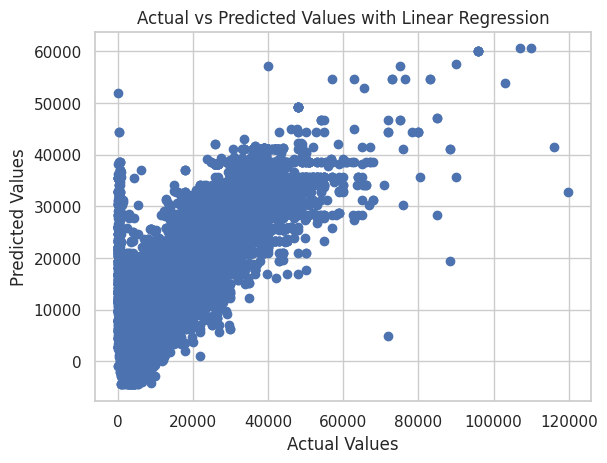

In [ ]:
plt.scatter(y_test, linear_preds)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values with Linear Regression')
plt.show()

In [ ]:
best_linear_coefs = best_linear_model.named_steps.lr.coef_
best_linear_features = best_linear_model.named_steps.sfs.get_feature_names_out()
best_linear_feature_indices = [int(s.replace('x' , '')) \
                               for s in best_linear_model.named_steps.sfs.get_feature_names_out()]
linear_pp_features = best_linear_model.named_steps.pp.get_feature_names_out()
best_linear_feature_columns = list(linear_pp_features[i] for i in best_linear_feature_indices)
pd.DataFrame({'features': best_linear_feature_columns, 'coef': best_linear_coefs})


,features,coef
0,manufacturer_toyota,3508.936826
1,model_corvette,19024.219987
2,model_corvette grand sport,17403.993875
3,cylinders_4 cylinders,-9789.445950
4,cylinders_6 cylinders,-4452.863292
5,transmission_automatic,-2654.350773
6,drive_fwd,-3723.910592
7,year,9280.599183
8,year^2,1937.191820


##### Ridge Regression Model

Run a Ridge regression model with similar parameters to the Linear Regression training. We will select `alpha`s between 0.01 to 1000. Perform K fold cross validation with k=4.

In [ ]:
ridge_pipeline = Pipeline([
    ('pp', transformer),
    ('sfs', SequentialFeatureSelector(estimator = Ridge())),
    ('ridge', Ridge())
])

ridge_params = {
    'pp__pipeline__poly__degree': list(range(1, 3)),
    'sfs__n_features_to_select': list(range(2, 10)),
    'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000]

}

ridge_grid = GridSearchCV(
    estimator = ridge_pipeline,
    param_grid = ridge_params,
    scoring = 'neg_mean_squared_error',
    cv = 5
)

ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['manufacturer',
                                                                          'model',
                                                                          'condition',
                                                                          'cylinders',
                                                                          'transmission',
                                                                          'drive',
                                                                          'type',
                                                                          'census_region']),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['year',
                                                                          'odometer'])],
                                                          verbose_feature_names_out=False)),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=Ridge())),
                                       ('ridge', Ridge())]),
             param_grid={'pp__pipeline__poly__degree': [1, 2],
                         'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000],
                         'sfs__n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [ ]:
print('Optimal Grid params were {}'.format(ridge_grid.best_params_))
best_ridge_model = ridge_grid.best_estimator_
best_ridge_model

Optimal Grid params were {'pp__pipeline__poly__degree': 2, 'ridge__alpha': 0.01, 'sfs__n_features_to_select': 9}


Pipeline(steps=[('pp',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'model',
                                                   'condition', 'cylinders',
                                                   'transmission', 'drive',
                                                   'type', 'census_region']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])],
                                   verbose_feature_names_out=False)),
                ('sfs',
                 SequentialFeatureSelector(estimator=Ridge(),
                                           n_features_to_select=9)),
                ('ridge', Ridge(alpha=0.01))])

In [ ]:
ridge_preds = best_ridge_model.predict(X_test)
print('MSE with ridge regression is {}'.format(mean_squared_error(y_test, ridge_preds)))

MSE with ridge regression is 53287139.27177388


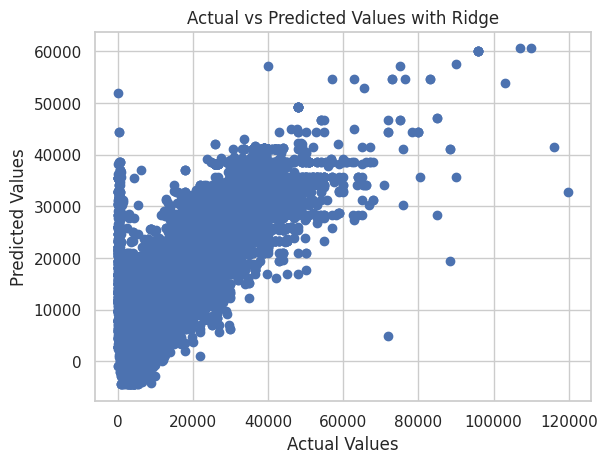

In [ ]:
plt.scatter(y_test, ridge_preds)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values with Ridge')
plt.show()

In [ ]:
best_ridge_coefs = best_ridge_model.named_steps.ridge.coef_
best_ridge_features = best_ridge_model.named_steps.sfs.get_feature_names_out()
best_ridge_feature_indices = [int(s.replace('x' , '')) \
                               for s in best_ridge_model.named_steps.sfs.get_feature_names_out()]
ridge_pp_features = best_ridge_model.named_steps.pp.get_feature_names_out()
best_ridge_feature_columns = list(ridge_pp_features[i] for i in best_ridge_feature_indices)
pd.DataFrame({'features': best_ridge_feature_columns, 'coef': best_ridge_coefs})

,features,coef
0,manufacturer_toyota,3508.920035
1,model_corvette,19023.696239
2,model_corvette grand sport,17403.098232
3,cylinders_4 cylinders,-9789.449562
4,cylinders_6 cylinders,-4452.877682
5,transmission_automatic,-2654.383493
6,drive_fwd,-3723.914585
7,year,9280.588127
8,year^2,1937.188330


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

##### Best Model

Based on the modeling exercise, both the Ridge model and Linear model performed equally well on the test set. The recommendation is to use the Ridge model with an `alpha=0.01`, `num_features=9` and `polynomial degree=2` for predicting the price.



##### Best drivers of price

Based on the modeling, we identified that the make/model of the car (especially higher-end models like corvette) and the year (age) are the best predictors of used car prices. The number of cylinders seem to be negatively correlated to the price, which could imply that 8 cylinder cars are likely to have the highest price. Similarly, automatic transmission and four wheel drive are negatively correlated to used car prices.

The top features identified by the model were:


*   The model Corvette
*   Year (and Year^2)
*   The manufacturer Toyota
*   4 and 6 cylinders (negative correlation)
*   Four Wheel Drive (negative correlation)
*   Automatic Transmission (negative correlation)





<ipython-input-66-4dbe1ea82230>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_cars.corr());


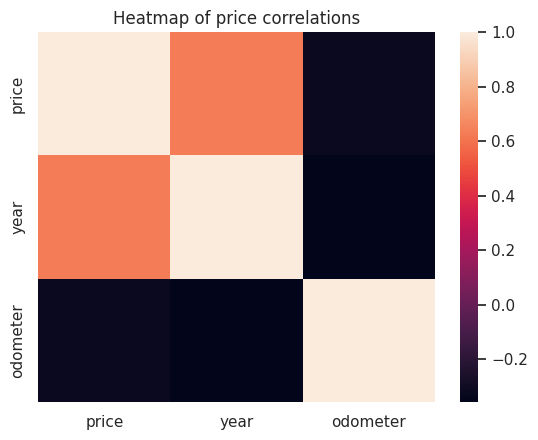

In [ ]:
sns.heatmap(df_cars.corr());
plt.title('Heatmap of price correlations')
plt.show()

As evident from the heatmap, odometer reading, which could have been another strong indicator of price does not play a major role based on our analysis.


##### Recommendation to client

The recommendation to the client would be to use these key drivers and the model to predict the price. Additionally, the client will derive value by analyzing the data by manufacturer and model.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

#### Deployment Plan

The model can be deployed rather quickly, however the training time is high. On a high RAM colab instance, the model training takes 2-3 hours. The client will have to be apprised about the machine resource cost associated with the solution.

The other action item around deployment would be to increase the quality of data collection. The client would benefit from collecting a dataset that has fewer empty values, possibly by contracting an external data company.

#### Deployment Report

Dear Client,

Based on analyzing and mining the dataset of around half a million used car sales, we have identified some key drivers that can maximize your used car sales revenue. We can confirm that the biggest driver of price is the age of the car, with other factors such as the engine type (number of cylinders) of the car being a strong consideration for your customers. High end cars such as corvette seem to command a high price, so does a reliable manufacturer such as Toyota.

We have been able to develop a model to predict the price, but would appreciate data from recent years and better labeling of manufacturer and model names to enable us to increase the precision of the model. A user interface can be built to accept key features of a car that you wish to sell, and this model should be able to predict the price range you should target to sell it for. Another application of this model could be to project your revenue based on your pipeline of incoming cars.

The top 10 car models that fetch the highest average prices are Corvette Grand Sport, RAM 1500, Mustang GT Coupe, Camaro SS Coupe, Tundra Double Cab SR, 4runner SR5 SUV, Challenger R/T Coupe, Silverado 1500 Crew, Wrangler Sport SUV, Tacoma Double Cab. Since this data might lead us to focus on muscle cars, trucks and SUVs, we recommend that we run a secondary analysis on the probability of purchase to make sure that your sales volumes are high.

Also, after deploying this model as an initial step, we would like to perform further analysis on the market using a technique called clustering. This will help us build more precise price prediction models for a group of similar car models.

Please let us know if there are additional objectives you would like us to explore.

Thanks,

